In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import scanpy as sc

In [4]:
file = ''
gdata = sc.read_visium(file, count_file=r'GSE198353_mmtv_pymt_GEX_filtered_feature_bc_matrix.h5',load_images=True)
gdata.var_names_make_unique()

In [5]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
pdata = sc.read_csv('GSE198353_mmtv_pymt_ADT_t.csv')
pdata.var_names_make_unique()

In [7]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32

In [8]:
pdata.obsm=gdata.obsm

In [9]:
pdata.uns = gdata.uns

In [10]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
#Normalization
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=2500)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

In [13]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

In [14]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

In [15]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

In [16]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\karan\appdata\roaming\python\python39\site-packages
Requires: tensorflow-intel
Required-by: 


In [17]:
!pip install --upgrade tensorflow

model.py

In [18]:
import tensorflow as tf
import tensorflow.compat.v1 as v1


class GATE():
    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30,alpha=0.8, nonlinear=True, weight_decay=0.0001):
        self.n_layers1 = len(hidden_dims1) - 1
        self.n_layers2 = len(hidden_dims2) - 1
        self.alpha = alpha
        self.W1, self.v1, self.prune_v1 = self.define_weights1(hidden_dims1, self.n_layers1)
        self.W2, self.v2, self.prune_v2 = self.define_weights2(hidden_dims2, self.n_layers2)
        self.C1 = {}
        self.C2 = {}
        self.prune_C1 = {}
        self.prune_C2 = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay
        self.z_dim = z_dim

        # Decoder 1
        self.W_dec1 = {}
        for layer in range(self.n_layers1 - 1, -1, -1):
            self.W_dec1[layer] = tf.Variable(tf.random.normal([hidden_dims1[layer+1], hidden_dims1[layer]]))

        # Decoder 2
        self.W_dec2 = {}
        for layer in range(self.n_layers2 - 1, -1, -1):
            self.W_dec2[layer] = tf.Variable(tf.random.normal([hidden_dims2[layer+1], hidden_dims2[layer]]))

    def __call__(self, A1,A2 ,prune_A, X1,X2):
        # Encoder 1
        H1 = X1
        for layer in range(self.n_layers1):
            H1 = self.__encoder1(A1, prune_A, H1, layer)
            if self.nonlinear:
                if layer != self.n_layers1 - 1:
                    H1 = tf.nn.elu(H1)

        # Encoder 2
        H2 = X2
        for layer in range(self.n_layers2):
            H2 = self.__encoder2(A2, prune_A, H2, layer)
            if self.nonlinear:
                if layer != self.n_layers2 - 1:
                    H2 = tf.nn.elu(H2)
        # Concatenate encoder outputs
        H = tf.concat([H1, H2], axis=1)

        # Call the third encoder
        global latent_rep 
        H = self.__encoder3(H)
        
        latent_rep = H

        temp=H
        H1=temp
        # Decoder 1
        for layer in range(self.n_layers1 - 1, -1, -1):
            H1 = self.__decoder1(H1, layer)
            if self.nonlinear:
                if layer != 0:
                    H1 = tf.nn.elu(H1)
        X1_ = H1

        H2=temp
        # Decoder 2
        for layer1 in range(self.n_layers2 - 1, -1, -1):
            H2 = self.__decoder2(H2, layer1)
            if self.nonlinear:
                if layer1 != 0:
                    H2 = tf.nn.elu(H2)
        X2_ = H2

        # Loss calculation
        features_loss = tf.sqrt(tf.reduce_sum(tf.pow(X1 - X1_, 2)))
        features_loss += tf.sqrt(tf.reduce_sum(tf.pow(X2 - X2_, 2)))

        weight_decay_loss = 0
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W2[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec2[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        self.loss = features_loss + weight_decay_loss

        if self.alpha == 0:
            self.Att_l = {'C1': self.C1, 'C2': self.C2}
        else:
            self.Att_l = {'C1': self.C1, 'C2': self.C2, 'prune_C1': self.prune_C1, 'prune_C2': self.prune_C2}
        return self.loss, latent_rep, self.Att_l, X1_, X2_
    
    def __encoder1(self, A, prune_A, H, layer):
        print('enc1 = ',H)
        H = tf.matmul(H, self.W1[layer])
        if layer == self.n_layers1 - 1:
            return H
        self.C1[layer] = self.graph_attention_layer(A, H, self.v1[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C1[layer], H)
        else:
            self.prune_C1[layer] = self.graph_attention_layer(prune_A, H, self.prune_v1[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer], H)
        
        

    def __encoder2(self, A, prune_A, H, layer):
        print('enc2 = ',H)
        H = tf.matmul(H, self.W2[layer])
        if layer == self.n_layers2 - 1:
            return H
        self.C2[layer] = self.graph_attention_layer(A, H, self.v2[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer], H)
        else:
            self.prune_C2[layer] = self.graph_attention_layer(prune_A, H, self.prune_v2[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer], H)
    
    def __decoder1(self, H, layer):
        print('dec1 = ',H)
        H = tf.matmul(H, self.W1[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:

            return tf.sparse.sparse_dense_matmul(self.C1[layer-1], H)
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer-1], H)
        
    def __decoder2(self, H, layer):
        print('dec2 = ',H)
        H = tf.matmul(H, self.W2[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer-1], H)
        
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer-1], H)
        

    def __encoder3(self, H):
        print('enc3 = ',H)
        H = tf.keras.layers.Dense(self.z_dim)(H)
        print('LATENT = ',H)
        return H


    def define_weights1(self,hidden_dims,n_layers):
        W = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers gene = ',n_layers)
        print('Hidden dim gene = ',hidden_dims)

        for i in range(n_layers):
            W[i] = v1.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(n_layers-1):
            V= {}
            V[0] = v1.get_variable("V%s_0" % i, shape=(hidden_dims[i+1], 1))
            V[1] = v1.get_variable("V%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = V
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(n_layers-1):
            prune_V = {}
            prune_V[0] = v1.get_variable("prune_V%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_V[1] = v1.get_variable("prune_V%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_V

        return W, Ws_att, prune_Ws_att
    
    def define_weights2(self,hidden_dims,n_layers):
        w = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers protein = ',n_layers)
        print('Hidden dim protein = ',hidden_dims)

        for i in range(n_layers):
            w[i] = v1.get_variable("w%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        ws_att = {}
        for i in range(n_layers-1):
            v = {}
            v[0] = v1.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = v1.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            ws_att[i] = v
        if self.alpha == 0:
            return w, ws_att, None
        prune_ws_att = {}
        for i in range(n_layers-1):
            prune_v = {}
            prune_v[0] = v1.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = v1.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_ws_att[i] = prune_v

        return w, ws_att, prune_ws_att
    


    def graph_attention_layer(self, A, M, v, layer):

        with v1.variable_scope("layer_%s" % layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = v1.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = v1.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions
        



stagate.py

In [19]:
import tensorflow as tf
import scipy.sparse as sp
import numpy as np
#from .model import GATE
import tensorflow.compat.v1 as v1
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, alpha=0, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020,
                 ):
        
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
           

        self.gate = GATE(hidden_dims1,hidden_dims2,z_dim,alpha, nonlinear, weight_decay)
        self.loss, self.H, self.C, self.ReX1, self.ReX2 = self.gate(self.A1,self.A2, self.prune_A, self.X1,self.X2)
        #print(self.loss, self.H, self.C, self.ReX1, self.ReX2,sep='\n')

        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A1 = v1.sparse_placeholder(dtype=tf.float32)
        self.A2 = v1.sparse_placeholder(dtype=tf.float32)
        self.prune_A = v1.sparse_placeholder(dtype=tf.float32)
        self.X1 = v1.placeholder(dtype=tf.float32)
        self.X2 = v1.placeholder(dtype=tf.float32)


    def build_session(self, gpu= True):
        config = v1.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = v1.Session(config=config)
        self.session.run([v1.global_variables_initializer(), v1.local_variables_initializer()])

    def optimize(self, loss):
        optimizer = v1.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A1, A2, prune_A, X1, X2):
        for epoch in range(self.n_epochs):
            self.run_epoch(epoch, A1, A2, prune_A, X1, X2)




    def run_epoch(self, epoch, A1,A2 ,prune_A, X1,X2):

        loss, _ = self.session.run([self.loss, self.train_op],
                           feed_dict={self.A1: A1,
                                      self.A2: A2,
                                      self.prune_A: prune_A,
                                      self.X1: X1,
                                      self.X2: X2})

        self.loss_list.append(loss)
        if self.verbose:
            print("Epoch: %s, Loss: %.4f" % (epoch, loss))
            
        return loss

    def infer(self, A1,A2, prune_A, X1,X2):
        global C
        H, C, ReX1, ReX2 = self.session.run([self.H, self.C, self.ReX1, self.ReX2],
                                    feed_dict={self.A1: A1,
                                               self.A2: A2,
                                               self.prune_A: prune_A,
                                               self.X1: X1,
                                               self.X2: X2})

        
        return H, self.Conbine_Atten_l(C['C1']), self.loss_list, ReX1,ReX2

    def Conbine_Atten_l(self, input):
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
            Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]


## bs

train_stagate.py

In [20]:
import numpy as np
import scipy.sparse as sp
#from .STAGATE import STAGATE
import tensorflow as tf
import pandas as pd
import scanpy as sc

def train_STAGATE(adata1,adata2, 
                hidden_dims1=[512, 30],hidden_dims2=[512, 30],z_dim=30, alpha=0, n_epochs=500, lr=0.0001, key_added='MY_ARCH',
                gradient_clipping=5, nonlinear=True, weight_decay=0.0001,verbose=True, 
                random_seed=2020, pre_labels=None, pre_resolution=0.2,
                save_attention=False, save_loss=False, save_reconstrction=False
                ):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    #tf.reset_default_graph()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    if 'highly_variable' in adata1.var.columns:
        adata_Vars1 =  adata1[:, adata1.var['highly_variable']]
    else:
        adata_Vars1 = adata1
    X1 = pd.DataFrame(adata_Vars1.X[:, ].toarray(), index=adata_Vars1.obs.index, columns=adata_Vars1.var.index)

    
    if 'highly_variable' in adata2.var.columns:
        adata_Vars2 =  adata2[:, adata2.var['highly_variable']]
    else:
        adata_Vars2 = adata2
    X2 = pd.DataFrame(adata_Vars2.X[:, ], index=adata_Vars2.obs.index, columns=adata_Vars2.var.index)

    if verbose:
        print('Size of Input for gene data : ', adata_Vars1.shape)
        print('Size of Input for protein data : ',adata_Vars2.shape)



    cells1 = np.array(X1.index)
    cells_id_tran1 = dict(zip(cells1, range(cells1.shape[0])))
    if 'Spatial_Net' not in adata1.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")

    Spatial_Net1 = adata1.uns['Spatial_Net']
    G_df1 = Spatial_Net1.copy()
    G_df1['Cell1'] = G_df1['Cell1'].map(cells_id_tran1)
    G_df1['Cell2'] = G_df1['Cell2'].map(cells_id_tran1)
    G1 = sp.coo_matrix((np.ones(G_df1.shape[0]), (G_df1['Cell1'], G_df1['Cell2'])), shape=(adata1.n_obs, adata1.n_obs))
    global G_tf1
    G_tf1 = prepare_graph_data(G1)

    cells2 = np.array(X2.index)
    cells_id_tran2 = dict(zip(cells2, range(cells2.shape[0])))
    if 'Spatial_Net' not in adata2.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net2 = adata1.uns['Spatial_Net']
    G_df2 = Spatial_Net2.copy()
    G_df2['Cell1'] = G_df2['Cell1'].map(cells_id_tran2)
    G_df2['Cell2'] = G_df2['Cell2'].map(cells_id_tran2)
    G2 = sp.coo_matrix((np.ones(G_df2.shape[0]), (G_df2['Cell1'], G_df2['Cell2'])), shape=(adata2.n_obs, adata2.n_obs))
    global G_tf2
    G_tf2 = prepare_graph_data(G2)

    tf.compat.v1.disable_eager_execution()
    trainer = STAGATE(hidden_dims1=[X1.shape[1]] + hidden_dims1,hidden_dims2=[X2.shape[1]] + hidden_dims2, z_dim=z_dim,alpha=alpha, 
                    n_epochs=n_epochs, lr=lr, gradient_clipping=gradient_clipping, 
                    nonlinear=nonlinear,weight_decay=weight_decay, verbose=verbose, 
                    random_seed=random_seed                    
                    )
    

    print("START TRAIN")
    
    #explain the code from here
    if alpha == 0:
        trainer(G_tf1, G_tf2, G_tf1, X1,X2)
        embeddings, attentions, loss, ReX1, ReX2= trainer.infer(G_tf1, G_tf2, G_tf1, X1,X2)
    else:
        G_df1 = Spatial_Net1.copy()
        if pre_labels==None:
            if verbose:
                print('------Pre-clustering adata1 using louvain with resolution=%.2f' %pre_resolution)
            sc.tl.pca(adata1, svd_solver='arpack')
            sc.pp.neighbors(adata1)
            sc.tl.louvain(adata1, resolution=pre_resolution, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df1, adata1.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran1)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran1)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf1[2])
        trainer(G_tf1, prune_G_tf, X1)
        embeddings, attentions, loss, ReX1, ReX2 = trainer.infer(G_tf1,G_tf2, prune_G_tf, X1,X2)

    global df
    cell_reps = pd.DataFrame(embeddings)
    df=cell_reps
    cell_reps.index = cells1

    adata1.obsm[key_added] = cell_reps.loc[adata1.obs_names, ].values
    if save_attention:
        adata1.uns['arch_attention'] = attentions
    if save_loss:
        adata1.uns['arch_loss'] = loss
    if save_reconstrction:
        ReX1 = pd.DataFrame(ReX1, index=X1.index, columns=X1.columns)
        ReX1[ReX1<0] = 0
        adata1.layers['arch_ReX1'] = ReX1.values
        ReX2 = pd.DataFrame(ReX2, index=X2.index, columns=X2.columns)
        ReX2[ReX2<0] = 0
        adata2.layers['archE_ReX2'] = ReX2.values

    return adata1




def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX1' in adata.uns)
    temp_df = adata.uns['ReX1'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count1'] = temp_df
    
    assert('ReX2' in adata.uns)
    temp_df = adata.uns['ReX2'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count2'] = temp_df

    return adata

    


utils.py

In [21]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


## not bs

Trying and debugging arch for new code

------Calculating spatial graph...


The graph contains 11434 edges, 1978 cells.
5.7806 neighbors per cell on average.


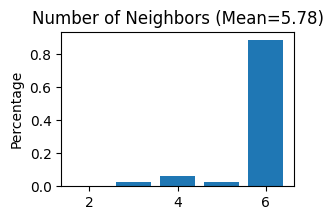

In [22]:
Cal_Spatial_Net(gdata, rad_cutoff=100)
Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 11434 edges, 1978 cells.
5.7806 neighbors per cell on average.


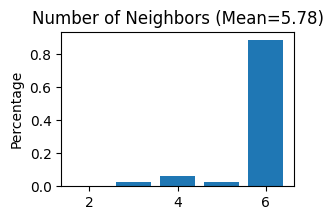

In [23]:
Cal_Spatial_Net(pdata, rad_cutoff=100)
Stats_Spatial_Net(pdata)

Gdata before training

In [24]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net'
    obsm: 'spatial'

In [25]:
gdata = train_STAGATE(gdata,pdata,n_epochs=500, alpha=0,save_attention=True, save_loss=True)

Size of Input for gene data :  (1978, 2500)
Size of Input for protein data :  (1978, 32)
n_layers gene =  2
Hidden dim gene =  [2500, 512, 30]
n_layers protein =  2
Hidden dim protein =  [32, 512, 30]
enc1 =  Tensor("Placeholder_9:0", dtype=float32)
enc1 =  Tensor("Elu:0", shape=(None, None), dtype=float32)
enc2 =  Tensor("Placeholder_10:0", dtype=float32)
enc2 =  Tensor("Elu_1:0", shape=(None, None), dtype=float32)
enc3 =  Tensor("concat:0", shape=(None, 60), dtype=float32)
LATENT =  Tensor("dense/BiasAdd:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("dense/BiasAdd:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("Elu_2:0", shape=(None, 512), dtype=float32)
dec2 =  Tensor("dense/BiasAdd:0", shape=(None, 30), dtype=float32)
dec2 =  Tensor("Elu_3:0", shape=(None, 512), dtype=float32)
START TRAIN
Epoch: 0, Loss: 3531.5349
Epoch: 1, Loss: 3437.2720
Epoch: 2, Loss: 3361.5366
Epoch: 3, Loss: 3302.1323
Epoch: 4, Loss: 3255.9082
Epoch: 5, Loss: 3218.7930
Epoch: 6, Loss: 3187.2664
Epo

Gdata after train

In [26]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'arch_attention', 'arch_loss'
    obsm: 'spatial', 'MY_ARCH'

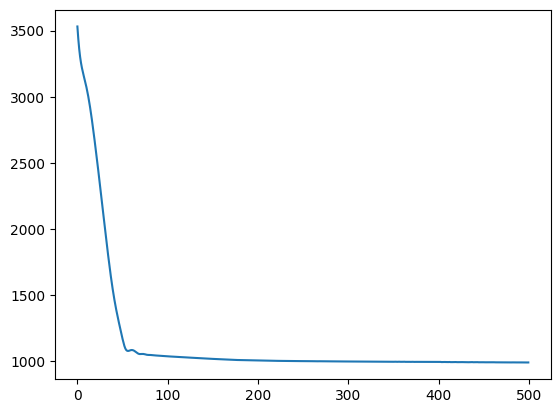

In [27]:
import matplotlib.pyplot as plt

plt.plot(gdata.uns['arch_loss'])
plt.show()

## Visualization of attention layer

In [28]:
gdata.uns['arch_attention']

[<1978x1978 sparse matrix of type '<class 'numpy.float32'>'
 	with 13412 stored elements in COOrdinate format>]

In [29]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'arch_attention', 'arch_loss'
    obsm: 'spatial', 'MY_ARCH'

In [30]:
import matplotlib as mpl
import networkx as nx


In [31]:
att_df1 = pd.DataFrame(gdata.uns['arch_attention'][0].toarray(), index=gdata.obs_names, columns=gdata.obs_names)
att_df1 = att_df1.values
for it in range(att_df1.shape[0]):
    att_df1[it, it] = 0
    
att_df2 = pd.DataFrame(pdata.uns['arch_attention'][0].toarray(), index=pdata.obs_names, columns=pdata.obs_names)
att_df2 = att_df2.values
for it in range(att_df2.shape[0]):
    att_df2[it, it] = 0

In [32]:
G_atten1 = nx.DiGraph(att_df1)
M1 = G_atten1.number_of_edges()
edge_colors1 = range(2, M1 + 2)

In [33]:
G_atten2 = nx.DiGraph(att_df2)
M2 = G_atten2.number_of_edges()
edge_colors2 = range(2, M2 + 2)

In [34]:
coor_df1 = pd.DataFrame(gdata.obsm['spatial'].copy(), index=gdata.obs_names)
coor_df1[1] = -1 * coor_df1[1]
image_pos1 = dict(zip(range(coor_df1.shape[0]), [np.array(coor_df1.iloc[it,]) for it in range(coor_df1.shape[0])]))

In [35]:
coor_df2 = pd.DataFrame(pdata.obsm['spatial'].copy(), index=pdata.obs_names)
coor_df2[1] = -1 * coor_df2[1]
image_pos2 = dict(zip(range(coor_df2.shape[0]), [np.array(coor_df2.iloc[it,]) for it in range(coor_df2.shape[0])]))

In [36]:
labels1 = nx.get_edge_attributes(G_atten1,'weight')
labels2 = nx.get_edge_attributes(G_atten2,'weight')

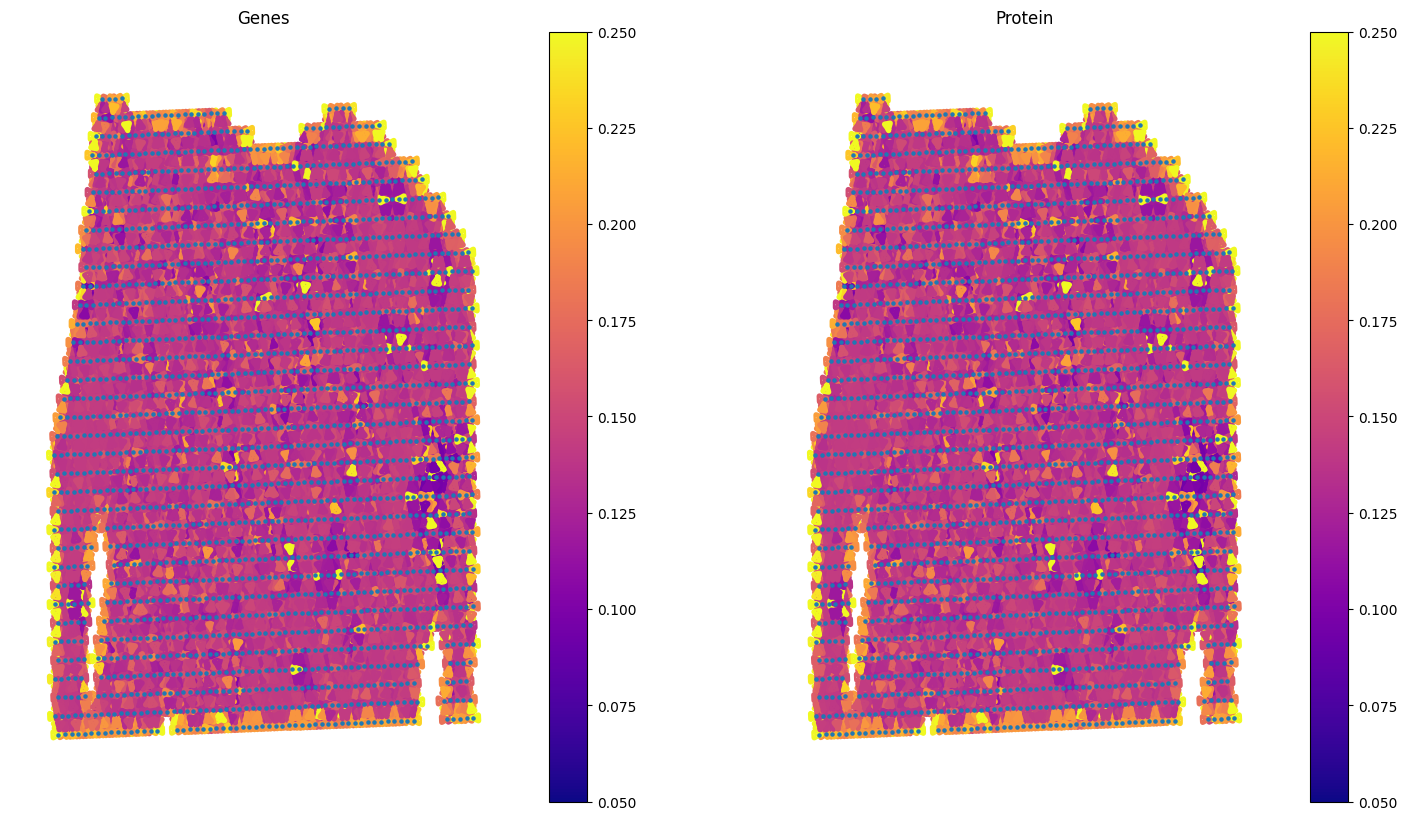

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 10])
ax1, ax2 = axes.flatten()

# Plot 1 - Genes
nx.draw_networkx_nodes(G_atten1, image_pos1, node_size=5, ax=ax1)

cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten1, image_pos1, edge_color=labels1.values(), width=4, ax=ax1,
                               edge_cmap=cmap, edge_vmax=0.25, edge_vmin=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.05, vmax=0.25))
sm._A = []

cbar = plt.colorbar(sm, ax=ax1)  # Specify the Axes to use for the colorbar

ax1.set_axis_off()
ax1.set_title("Genes")

# Plot 2 - Protein
nx.draw_networkx_nodes(G_atten2, image_pos2, node_size=5, ax=ax2)

cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten2, image_pos2, edge_color=labels1.values(), width=4, ax=ax2,
                               edge_cmap=cmap, edge_vmax=0.25, edge_vmin=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.05, vmax=0.25))
sm._A = []

cbar = plt.colorbar(sm, ax=ax2)  # Specify the Axes to use for the colorbar

ax2.set_axis_off()
ax2.set_title("Protein")

plt.show()



## saving the Latent Rep

In [39]:
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
AAACAAGTATCTCCCA-1,0.007441,1.641778,12.943107,-10.064323,-7.207676,7.197922,13.607068,-2.486499,-6.084158,1.236389,...,-2.391908,-6.317616,5.808222,4.022294,2.022887,2.481869,-1.545570,8.217969,2.870439,-6.457936
AAACACCAATAACTGC-1,0.508322,2.118709,19.318874,-12.193954,-9.311971,11.286652,19.356894,-4.205674,-9.148844,1.584125,...,-0.435198,-8.794517,8.235598,4.688315,1.733874,4.630150,-4.840258,13.331148,2.488243,-8.166883
AAACAGGGTCTATATT-1,1.004628,3.433859,19.285376,-11.310205,-11.787666,9.001374,14.472363,-4.470294,-7.768521,2.941674,...,-2.271235,-7.713414,7.408049,5.867831,6.492270,5.276245,-4.796163,10.319940,3.358179,-8.207011
AAACAGTGTTCCTGGG-1,0.949104,1.488341,17.840668,-13.235577,-8.745703,12.665673,19.450275,-3.063551,-7.900626,1.265416,...,-0.119153,-8.670651,7.013887,4.090447,0.195740,2.855123,-3.377511,13.963477,2.846739,-6.985480
AAACATGGTGAGAGGA-1,0.726189,3.115787,20.228996,-12.525280,-10.905689,10.745824,17.743818,-5.142045,-9.148654,2.287503,...,-1.338098,-9.479797,8.802092,4.951656,4.170001,5.490481,-6.230799,12.439657,2.901356,-9.295527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGGCAATGACTG-1,0.642917,2.277535,19.744864,-13.260253,-9.203616,13.510628,20.818213,-3.901957,-8.797323,1.614871,...,0.171676,-9.169364,7.592945,4.576333,1.370521,3.899567,-4.541402,15.157570,2.481481,-7.611318
TTGTTTCACATCCAGG-1,0.525885,1.402072,17.884806,-12.254744,-8.383096,12.051034,19.524685,-3.370240,-8.123577,1.190769,...,0.042465,-8.127805,6.954813,4.524789,0.571261,3.642623,-3.325863,13.613703,2.509286,-6.843512
TTGTTTCATTAGTCTA-1,0.790848,1.487535,18.036684,-12.410896,-8.512039,12.138771,18.864744,-3.371923,-7.948470,1.171553,...,0.062390,-8.017822,7.002114,4.228829,0.434237,3.113367,-3.328303,13.352999,2.353913,-7.062680
TTGTTTCCATACAACT-1,0.768126,2.738992,19.076788,-11.613944,-10.381802,10.145858,16.898506,-4.264935,-8.242715,2.337739,...,-1.222959,-8.152308,7.688410,5.397952,3.888324,4.761496,-4.560903,11.922574,2.701191,-7.772145


In [40]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'arch_attention', 'arch_loss'
    obsm: 'spatial'

In [41]:
# Write the 'data' variable to a file in CSV format
np.savetxt('data.csv', gdata.obsm['MY_ARCH'], delimiter=',')

In [42]:
ok = pd.read_csv('results.csv')
result = ok.to_numpy()

In [43]:
sc.pp.neighbors(gdata, use_rep='MY_ARCH')
sc.tl.umap(gdata)
#gdata = STAGATE.mclust_R(gdata, used_obsm='STAGATE', num_cluster=5)

clustering for 4 clusters

In [44]:
mclust_res = result
gdata.obs['mclust'] = mclust_res
gdata.obs['mclust'] = gdata.obs['mclust'].astype('int')
gdata.obs['mclust'] = gdata.obs['mclust'].astype('category')
obs_df = gdata.obs.dropna()


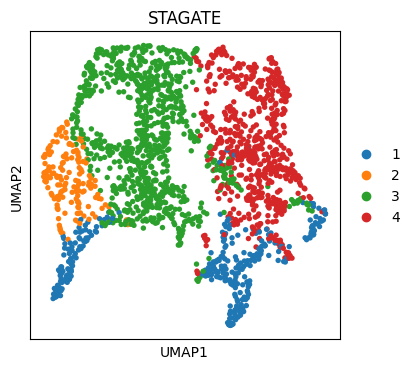

In [45]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(gdata, color=["mclust"], title=['STAGATE'])

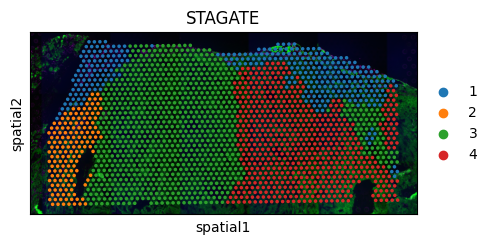

In [46]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(gdata, color=["mclust"], title=['STAGATE'])

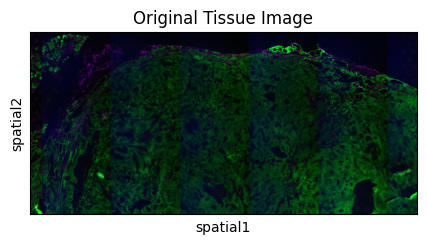

In [47]:
sc.pl.spatial(gdata,  title=['Original Tissue Image'])

clustering with 8 clusters

In [48]:
ok = pd.read_csv('results.csv')
result = ok.to_numpy()

In [49]:
mclust_res = result
gdata.obs['mclust'] = mclust_res
gdata.obs['mclust'] = gdata.obs['mclust'].astype('int')
gdata.obs['mclust'] = gdata.obs['mclust'].astype('category')
obs_df = gdata.obs.dropna()


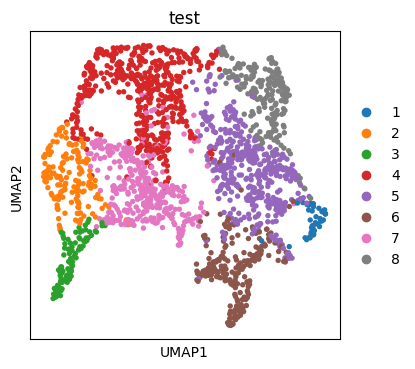

In [50]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(gdata, color=["mclust"], title=['test'])

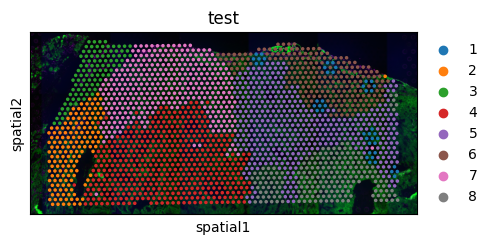

In [51]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(gdata, color=["mclust"], title=['test'])